In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

import tensorflow as tf

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import AdversarialPatch
import pandas as pd
import os
import cv2
from PIL import Image

In [2]:

    
tf.compat.v1.disable_eager_execution()

In [3]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [4]:
train_path = "data/Train"
test_path = "data/Test"
data_dir = 'data'
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3
NUM_CATEGORIES = len(os.listdir(train_path))

In [5]:
from keras.models import load_model
model = load_model('models/kaggle_model.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
tfc = KerasClassifier(model=model, clip_values=(0, 255))

In [7]:
model

In [51]:
test = pd.read_csv(os.path.join(data_dir, 'Train.csv'))

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    image = cv2.imread(os.path.join(data_dir, img))
    image_fromarray = Image.fromarray(image, 'RGB')
    data.append(np.array(image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))))

In [52]:
np.sum(labels==14)

780

In [53]:
data = np.array(data)

In [54]:
data.shape

(39209, 30, 30, 3)

In [55]:
labels

array([20, 20, 20, ..., 42, 42, 42], dtype=int64)

In [57]:
stop_data = data[labels==14]

In [58]:
stop_data.shape

(780, 30, 30, 3)

In [59]:
stop_data.shape

(780, 30, 30, 3)

In [60]:
clip_values = (0, 255)

batch_size = 16
scale_min = 0.2
scale_max = 0.8
rotation_max = 90
learning_rate = 1.
max_iter = 5000

image_shape = (IMG_HEIGHT, IMG_WIDTH, 3)


In [61]:
def change_black_to_white(img):
    img[img == 0] = 255
    return img
def bgr_to_rgb(x):
  return x[:, :, ::-1]
patches, patch_masks = [], []
def evaluate(ap, classifier, scale, target_y):
  # Evaluate the classifier on the adversarial examples
  patched_images = ap.apply_patch(stop_data, scale)
  predictions = classifier.predict(patched_images.astype(np.float32))
  return [x.all() for x in target_y == predictions]
def generate_attack(evasion, nb_examples):
  nb_classes  = len(classes)
  label = evasion  #evasion destination
  y_one_hot = np.zeros(nb_classes)
  y_one_hot[label] = 1.0
  y_target = np.tile(y_one_hot, (stop_data.shape[0], 1))
  ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_shape=(10,10,3),targeted=False)
  patch, patch_mask = ap.generate(x=stop_data[:nb_examples],y = y_target[:nb_examples])
  results = []
  for x in range(0, 100, 10):
    results.append(np.sum(evaluate(ap, tfc, x/100, y_target))/len(stop_data)*100)
  return patch, patch_mask, results


In [64]:
evasions = [8, 12]
nb_examples = [1, 2, 10]
results = []
for evasion in evasions:
    for nb_example in nb_examples:
      patch, patch_mask, results = generate_attack(evasion, nb_example)
      plt.imsave(f'patch_{evasion}_{nb_example}.png', change_black_to_white((bgr_to_rgb(patch) * patch_mask).astype(np.uint8)))
      patches.append(patch)
      patch_masks.append(patch_mask)
      results.append(results)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Adversarial Patch Numpy: 100%|██████████| 5000/5000 [00:51<00:00, 97.33it/s] 


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Adversarial Patch Numpy: 100%|██████████| 5000/5000 [01:15<00:00, 66.07it/s]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Adversarial Patch Numpy: 100%|██████████| 5000/5000 [04:20<00:00, 19.23it/s]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Adversarial Patch Numpy: 100%|██████████| 5000/5000 [00:44<00:00, 112.32it/s]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Adversarial Patch Numpy: 100%|██████████| 5000/5000 [01:13<00:00, 67.60it/s]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Adversarial Patch Numpy: 100%|██████████| 5000/5000 [04:46<00:00, 17.48it/s]


In [100]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]

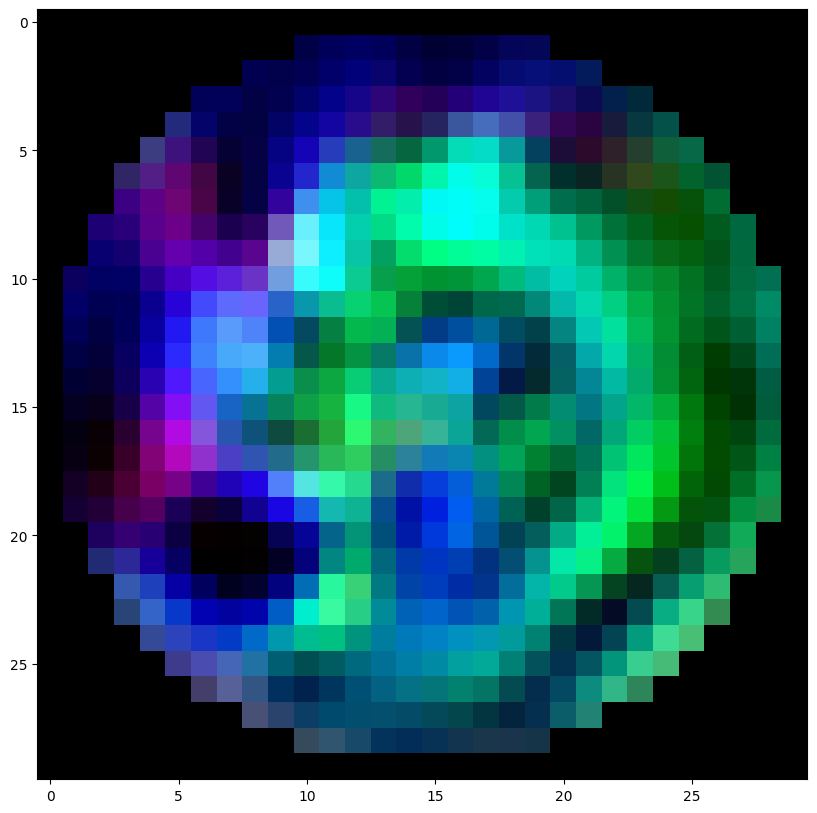

In [111]:
plt.imshow(change_black_to_white((bgr_to_rgb(patch) * patch_mask).astype(np.uint8)))

In [103]:
#change black pixels to white
def change_black_to_white(img):
    img[img == 0] = 255
    return img
plt.imsave('patch.png', change_black_to_white((bgr_to_rgb(patch) * patch_mask).astype(np.uint8)))

14
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


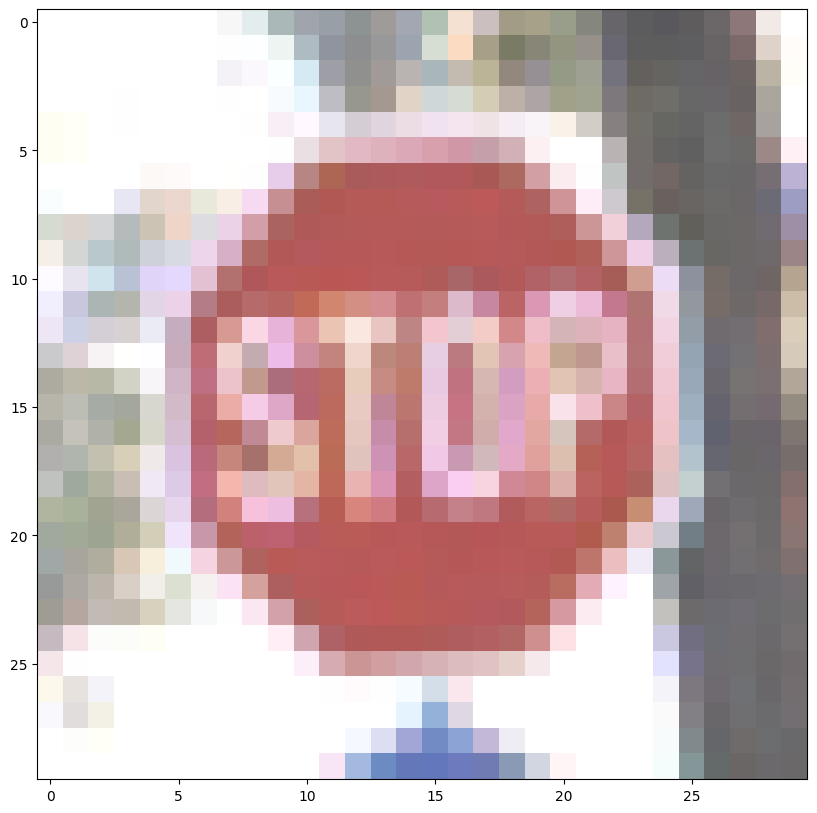

In [104]:
image = stop_data[0:1]
prediction = tfc.predict(image.astype(np.float32))
print(np.argmax(prediction))
print(prediction)
plt.imshow(bgr_to_rgb(image[0].astype(np.uint8)))
plt.show()


In [105]:
patched_images = ap.apply_patch(stop_data[:1], 0.2)
predictions = tfc.predict(patched_images.astype(np.float32))

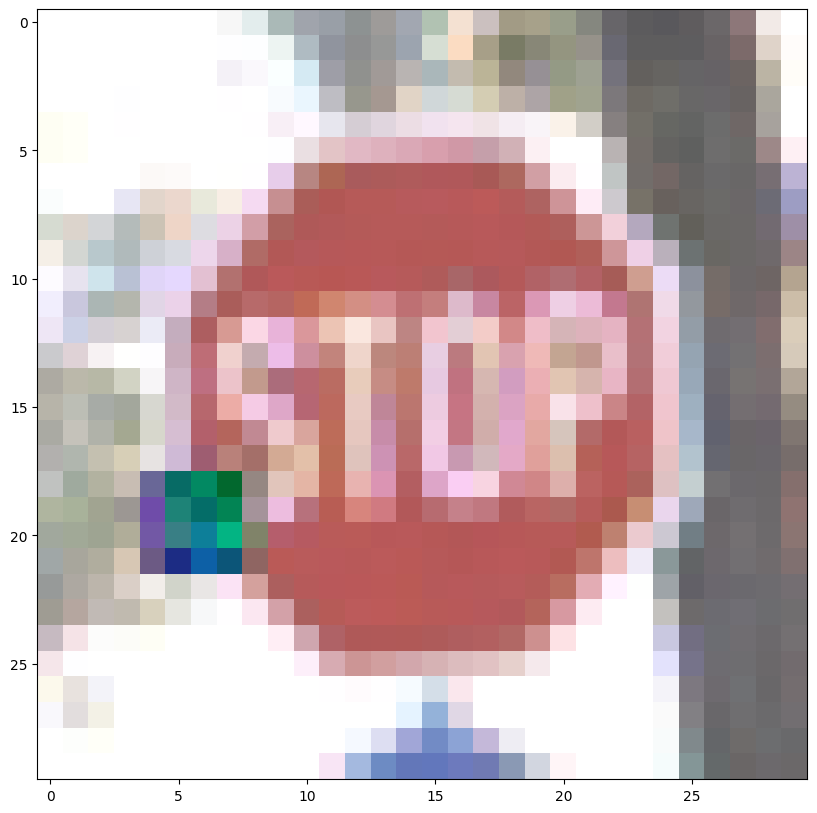

In [106]:

plt.imshow(bgr_to_rgb(patched_images[0].astype(np.uint8)))

14


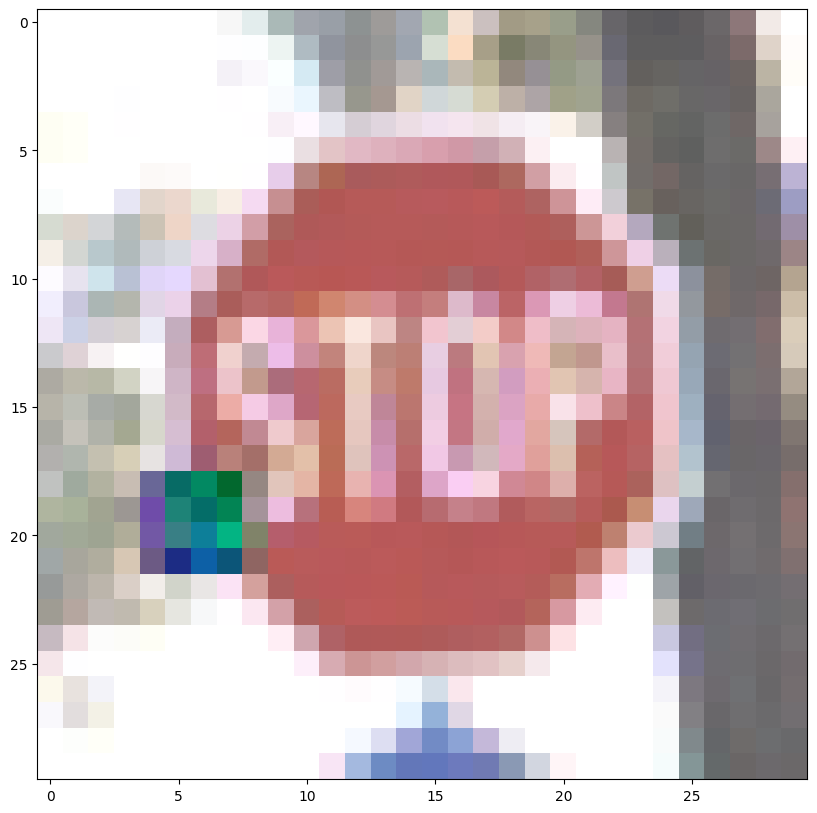

In [107]:
image = patched_images[0:1]
prediction = tfc.predict(image.astype(np.float32))
print(np.argmax(prediction))
plt.imshow(bgr_to_rgb(image[0].astype(np.uint8)))
plt.show()


In [108]:
def evaluate(classifier, scale, target_y):
  # Evaluate the classifier on the adversarial examples
  patched_images = ap.apply_patch(stop_data, scale)
  predictions = classifier.predict(patched_images.astype(np.float32))
  return [x.all() for x in target_y == predictions]

In [109]:
results = []
for x in range(0, 100, 10):
  results.append(np.sum(evaluate(tfc, x/100, y_target))/len(stop_data)*100)

In [110]:
results

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.153846153846154,
 35.51282051282051,
 61.92307692307693,
 59.48717948717949,
 14.358974358974358]